In [1]:
import cv2
import numpy as np
import pandas as pd
from imutils import paths

import os,random,glob
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img,array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D,Dropout,SpatialDropout2D,BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dir='/content/drive/MyDrive/Garbage classification/'

In [3]:
target_size=(250,250)
waste_labels={'cardboard':0,
        'paper':1,
        'metal':2,
        'plastic':3,
        'glass':4,
        'trash':5}


In [4]:
def load_data(path):
  x=[]
  labels=[]
  image_paths=sorted(list(paths.list_images(path)))
  for image_path in image_paths:
    img=cv2.imread(image_path)

    img=cv2.resize(img,target_size)
    x.append(img)
    label=image_path.split(os.path.sep)[-2]

    labels.append(waste_labels[label])
  x,labels=shuffle(x,labels,random_state=42)
  inp_shape=(np.array(x[0]).shape[1],np.array(x[0]).shape[1],3)
  print("x shape",np.array(x).shape)
  print(f"number of labels:{len(np.unique(labels))},number of observations:{len(labels)}")
  print('input shape',inp_shape)
  return x,labels,inp_shape
x,labels,inp_shape=load_data(dir)

x shape (2527, 250, 250, 3)
number of labels:6,number of observations:2527
input shape (250, 250, 3)


In [5]:
def dataprep():
  train=ImageDataGenerator(horizontal_flip=True,
                           vertical_flip=True,
                           validation_split=0.1,
                           rescale=1./255,
                           shear_range=0.1,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1)
  test=ImageDataGenerator(rescale=1/255,validation_split=0.1)
  train_generator=train.flow_from_directory(directory=dir,target_size=(target_size),class_mode="categorical",subset="training")
  test_generator=test.flow_from_directory(directory=dir,target_size=(target_size),class_mode="categorical",subset="validation")
  return train_generator,test_generator


In [6]:
train_generator,test_generator=dataprep()

Found 2276 images belonging to 6 classes.
Found 251 images belonging to 6 classes.


In [53]:
def modelling(train_generator, test_generator, summary=True, fit=True, epochs=200):
  model = Sequential()

  model.add(Conv2D(filters=16, kernel_size=(2,2), padding="same", input_shape=(inp_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))

  model.add(Conv2D(filters=16, kernel_size=(2,2), padding="same", input_shape=(inp_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))


  model.add(Conv2D(filters=16, kernel_size=(2,2), padding="same", input_shape=(inp_shape), activation="relu"))
  model.add(MaxPooling2D(pool_size=2, strides=(2,2)))
  model.add(Flatten())
  from tensorflow.keras.optimizers import Adam



  model.add(Dense(units=6, activation="sigmoid"))
  custom_optimizer = Adam(learning_rate=0.001)

  model.compile(optimizer=custom_optimizer,loss='categorical_crossentropy',

                metrics=[tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), "acc"])



  if summary:
    model.summary()

  if fit:
    history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=test_generator,initial_epoch=150,
                                workers=4, steps_per_epoch=30, validation_steps=251//32)
  return model, history



In [54]:
model,history=modelling(train_generator,test_generator)

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_32 (Conv2D)          (None, 250, 250, 16)      208       
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 125, 125, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_33 (Conv2D)          (None, 125, 125, 16)      1040      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 62, 62, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 62, 62, 16)        1040      
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 31, 31, 16)     

<ipython-input-53-bad7932f5312>:31: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_generator, epochs=epochs, validation_data=test_generator,initial_epoch=150,


Epoch 151/200
30/30 [==============================] - 72s 2s/step - loss: 1.6377 - precision_11: 0.2319 - recall_11: 0.6708 - acc: 0.3104 - val_loss: 1.5426 - val_precision_11: 0.2632 - val_recall_11: 0.6473 - val_acc: 0.3170
Epoch 152/200
30/30 [==============================] - 71s 2s/step - loss: 1.4681 - precision_11: 0.2948 - recall_11: 0.7200 - acc: 0.4024 - val_loss: 1.4619 - val_precision_11: 0.3253 - val_recall_11: 0.6652 - val_acc: 0.3973
Epoch 153/200
30/30 [==============================] - 71s 2s/step - loss: 1.3756 - precision_11: 0.3436 - recall_11: 0.6531 - acc: 0.4417 - val_loss: 1.3511 - val_precision_11: 0.3828 - val_recall_11: 0.5759 - val_acc: 0.4375
Epoch 154/200
30/30 [==============================] - 75s 2s/step - loss: 1.3385 - precision_11: 0.3809 - recall_11: 0.6159 - acc: 0.4657 - val_loss: 1.3568 - val_precision_11: 0.3481 - val_recall_11: 0.5268 - val_acc: 0.4107
Epoch 155/200
30/30 [==============================] - 72s 2s/step - loss: 1.2655 - precisio

In [55]:
def modellingtest(path):
  img = image.load_img(path, target_size=(target_size))
  img = image.img_to_array(img, dtype=np.uint8)
  img = np.array(img)/255.0
  p = model.predict(img.reshape(1,250,250,3))
  predicted_class = np.argmax(p[0])
  return img, p, predicted_class

In [56]:


img, p, predicted_class = modellingtest('/content/drive/MyDrive/Garbage classification/metal/metal100.jpg')

1/1 [==============================] - 0s 162ms/step


In [57]:
waste_labels = {0:"cardboard", 1:"glass", 2:"metal", 3:"paper", 4:"plastic", 5:"trash"}
def plot_model_testing(img, p, predicted_class):
  plt.axis("off")
  plt.imshow(img.squeeze())
  plt.title("Maximum Probabilty: " + str(np.max(p[0], axis=-1)) + "\n" + "Predicted Class: " + str(waste_labels[predicted_class]))
  plt.imshow(img);

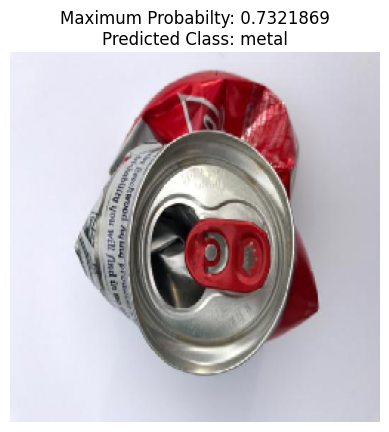

In [59]:
plot_model_testing(img, p, predicted_class)

In [62]:
from tensorflow.keras.models import load_model, save_model
model.save('/content/drive/MyDrive/trashmodel.h5')

In [58]:
import matplotlib.pyplot as plt